 # Valuación de Opciones de Barrera con Monte Carlo

In [13]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
 
def price_barrier_option(option_type, ticker, K, barrier_price, r=0.05, num_simulations=10000):
    data = yf.download(ticker, start='2022-01-01', end='2025-10-15', progress = False,auto_adjust=True)  
    close = data['Close'].squeeze()
    daily_returns = close.pct_change().dropna()
 
    # Parámetros
    S0 = float(close.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    T_days = 252
    T = 1
    dt = T / T_days
 
    #  Simulación de trayectorias
    Z = np.random.normal(0, 1, (num_simulations, T_days))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S = S0 * np.exp(log_paths)
    S = np.concatenate([np.full((num_simulations, 1), S0), S], axis=1)
 
    #  Barrera (up-and-out)
    barrier_breached = (S > barrier_price).any(axis=1)
    ST = S[:, -1]
 
    #  Payoff
    if option_type == 'call':
        payoffs = np.where(~barrier_breached, np.maximum(ST - K, 0), 0)
    else:
        payoffs = np.where(~barrier_breached, np.maximum(K - ST, 0), 0)
 
    #  Precio descontado
    price = np.exp(-r * T) * np.mean(payoffs)
 
    return float(S0), float(price)
 
 
#  Ejemplo de uso
S0, price = price_barrier_option('put', 'SPY', K=680, barrier_price=700)
print(f"Precio actual del subyacente (S0): {S0:.2f}")
print(f"Precio estimado de la opción barrera: {price:.4f}")

Precio actual del subyacente (S0): 662.23
Precio estimado de la opción barrera: 22.9539


## Ejercicio 1 – Sensibilidad al nivel de barrera**
**Fija los parámetros:**

option_type = 'call'

ticker = 'SPY'

K = 680

r = 0.05

**Simula el precio de la opción para cinco niveles de barrera:**
700, 710, 720, 730 y 740.

**Muestra los resultados en una tabla y grafica:**

Eje X: nivel de barrera.

Eje Y: precio estimado de la opción.

**Pregunta guía: ¿Qué relación observas entre la altura de la barrera y el valor de la opción?**

Nivel de barrera | Precio estimado de la opción
-----------------------------------------------
700               | 0.0378
710               | 0.1302
720               | 0.2894
730               | 0.6681
740               | 1.0858


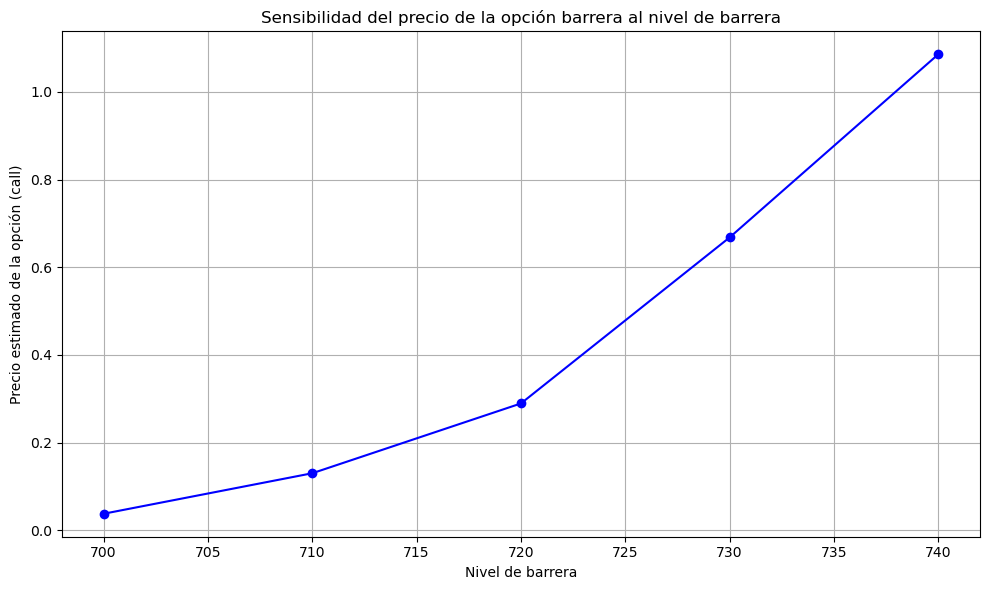

In [14]:
# Ejercicio 1 

option_type = 'call'
ticker = 'SPY'
K = 680
r = 0.05
barrier_levels = [700, 710, 720, 730, 740]

# Guardar resultados
prices = []
print("Nivel de barrera | Precio estimado de la opción")
print("-----------------------------------------------")
for barrier in barrier_levels:
    S0, option_price = price_barrier_option(option_type, ticker, K, barrier, r)
    prices.append(option_price)
    print(f"{barrier:<17} | {option_price:.4f}")

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(barrier_levels, prices, marker='o', linestyle='-', color='blue')
plt.title('Sensibilidad del precio de la opción barrera al nivel de barrera')
plt.xlabel('Nivel de barrera')
plt.ylabel('Precio estimado de la opción (call)')
plt.grid(True)
plt.tight_layout()
plt.show()

A medida que la barrera sube (más lejos del precio actual), el valor de la opción aumenta.

## Ejercicio 2 – Sensibilidad a la volatilidad
**Modifica la función para incluir un argumento sigma_override que permita reemplazar la volatilidad histórica.**
Si sigma_override no es None, úsalo en lugar de daily_returns.std() * np.sqrt(252).

**Evalúa el precio de la opción para cuatro niveles de volatilidad:**
0.1, 0.2, 0.3 y 0.4.

**Grafica cómo cambia el precio con la volatilidad.**

In [15]:
def price_barrier_option(option_type, ticker, K, barrier_price, r=0.05, num_simulations=10000, sigma_override=None):
    data = yf.download(ticker, start='2022-01-01', end='2025-10-15',progress = False, auto_adjust=True)  
    close = data['Close'].squeeze()
    daily_returns = close.pct_change().dropna()

    # Último precio
    S0 = float(close.iloc[-1])
    
    # Usar sigma_override si se proporciona
    if sigma_override is not None:
        sigma = sigma_override
    else:
        sigma = daily_returns.std() * np.sqrt(252)  # Volatilidad histórica anualizada

    # Parámetros de simulación
    T_days = 252
    T = 1
    dt = T / T_days

    Z = np.random.normal(0, 1, (num_simulations, T_days))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S = S0 * np.exp(log_paths)
    S = np.concatenate([np.full((num_simulations, 1), S0), S], axis=1)

    # Barrera (up-and-out)
    barrier_breached = (S > barrier_price).any(axis=1)
    ST = S[:, -1]

    # Payoff
    if option_type == 'call':
        payoffs = np.where(~barrier_breached, np.maximum(ST - K, 0), 0)
    else:
        payoffs = np.where(~barrier_breached, np.maximum(K - ST, 0), 0)

    # Precio descontado
    price = np.exp(-r * T) * np.mean(payoffs)

    return float(S0), float(price)

Volatilidad | Precio estimado de la opción
------------------------------------------
0.1         | 0.1524
0.2         | 0.0264
0.3         | 0.0105
0.4         | 0.0081


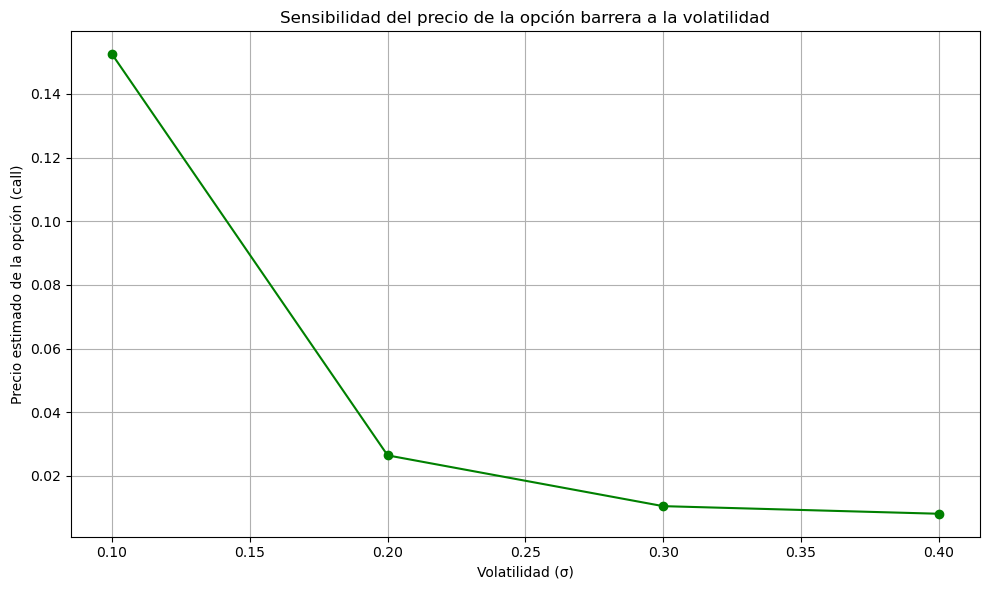

In [16]:
# Ejercicio 2 – Sensibilidad a la volatilidad

option_type = 'call'
ticker = 'SPY'
K = 680
barrier_price = 700
r = 0.05
volatilities = [0.1, 0.2, 0.3, 0.4]

prices = []
print("Volatilidad | Precio estimado de la opción")
print("------------------------------------------")
for sigma in volatilities:
    S0, option_price = price_barrier_option(option_type, ticker, K, barrier_price, r, sigma_override=sigma)
    prices.append(option_price)
    print(f"{sigma:<11} | {option_price:.4f}")

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(volatilities, prices, marker='o', linestyle='-', color='green')
plt.title('Sensibilidad del precio de la opción barrera a la volatilidad')
plt.xlabel('Volatilidad (σ)')
plt.ylabel('Precio estimado de la opción (call)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Ejercicio 3 – Comparación con una opción sin barrera
**Modifica el código para calcular el precio de una opción europea estándar (sin barrera).**

Compara ambos precios (con y sin barrera) para los mismos parámetros.


**Pregunta: ¿Por qué el precio de la opción barrera siempre debe ser menor o igual que el de una opción europea equivalente**

In [19]:
# opción europea estándar (sin barrera)
def price_vanilla_option(option_type, ticker, K, r=0.05, num_simulations=10000, sigma_override=None):
    data = yf.download(ticker, start='2022-01-01', end='2025-10-15',progress = False, auto_adjust=True)  
    close = data['Close'].squeeze()
    daily_returns = close.pct_change().dropna()
    S0 = float(close.iloc[-1])

    if sigma_override is not None:
        sigma = sigma_override
    else:
        sigma = daily_returns.std() * np.sqrt(252)

    T_days = 252
    T = 1
    dt = T / T_days

    Z = np.random.normal(0, 1, (num_simulations, T_days))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S = S0 * np.exp(log_paths)

    ST = S[:, -1]

    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    return float(S0), float(price)

In [20]:
# Parámetros
option_type = 'call'
ticker = 'SPY'
K = 680
barrier_price = 700
r = 0.05

# Calcular precios
S0, barrier_price_val = price_barrier_option(option_type, ticker, K, barrier_price, r)
_, vanilla_price_val = price_vanilla_option(option_type, ticker, K, r)

# Mostrar resultados
print("\nComparación de precios:")
print(f"Precio actual del activo (S0): {S0:.2f}")
print(f"Precio opción barrera:         {barrier_price_val:.4f}")
print(f"Precio opción europea estándar: {vanilla_price_val:.4f}")



Comparación de precios:
Precio actual del activo (S0): 662.23
Precio opción barrera:         0.0385
Precio opción europea estándar: 55.8650


El valor de una opción barrera knock-out siempre será menor o igual al valor de una opción europea estándar con los mismos parámetros (S0, K, T, r, σ) porque añade una restricción adicional que puede eliminar completamente su valor.

La opción barrera tipo knock-out tiene una condición adicional: si el precio toca o supera la barrera, la opción se anula completamente, incluso si hubiera estado in-the-money al vencimiento.